In [ ]:
#| echo: false
from typing import Union, Tuple, List
from PIL import Image, ImageDraw
import math
import random
from sympy import flatten
from numpy.linalg import norm

import numpy as np
from typing import List, Tuple
import math
from math import cos, sin, tan, pi
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.affinity import rotate
from shapely.ops import unary_union

import gymnasium as gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#| echo: false
def compute_corners(squares: List[Tuple[float, float, float]], sideLen=1):
    rtn = []
    for x, y, rot_rad in squares:
        # Compute the coordinates of the four corners of the square
        half_side = sideLen / 2
        corners = [(half_side, half_side), (half_side, -half_side), (-half_side, -half_side), (-half_side, half_side)]
        rotated_corners = []
        for corner in corners:
            rotated_x = x + corner[0]*math.cos(rot_rad) - corner[1]*math.sin(rot_rad)
            rotated_y = y + corner[0]*math.sin(rot_rad) + corner[1]*math.cos(rot_rad)
            rotated_corners.append((rotated_x, rotated_y))
        rtn.append(rotated_corners)
    return rtn


def convert2shapely(squares:List[Tuple[float, float, float]], side_len:float=1.0) -> List[Polygon]:
    return [Polygon(corners) for corners in compute_corners(squares, sideLen=side_len)]


My senior project is to attempt to use a reinforcement learning algorithm based on a [Deep Deterministic Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) model for use with a continuous observation *and* action space, in order to solve the [Square Packing in a Square](https://en.wikipedia.org/wiki/Square_packing) problem for N=11 squares.

That was a very intelligent sounding sentence. Let's break it down:


### Square Packing in a Square
The [*Square Packing in a Square*](https://en.wikipedia.org/wiki/Square_packing) problem is an unsolved problem in mathematics where the goal is to pack `N` squares with a side length of 1 into another square, while wasting as little space as possible. 

The technical wording is
        
> What is the asymptotic growth rate of wasted space for square packing in a half-integer square?

I'm not going to be solving that. Instead I'm going to attempt to use Reinforcement Learning (RL) to attempt to figure out a better solution for me. I have no idea how well it will work.

There are known configurations for N=1-10 squares, but 11 (and some others) are only approximately solved. This tries to find a more optimal configuration for N=11 squares by using RL instead of pure math.

The theoretial optimal packing has a side length of 3.789, but the best known is 3.877084

![](wiki_snip.png)

### DDPG
[DDPG](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) model is a kind of [actor-critic](https://www.mathworks.com/help/reinforcement-learning/ref/rl.agent.rlacagent.html) setup (not technically a model) that allows continuous rather than discrete observation and action spaces. This is important, because I want to find a very precise solution, as opposed to infinitely increasing the discrete resolution of steps the AI can take.

An actor-critic setup has 2 models (though the DDPG setup has 4, for training purposes). One model is the actor, which takes in an observation from the enviorment, learns to outputs actions to take in the enviorment, optimized to some reward function. The other model takes in an observation from the enviorment and the action taken by the actor for that observation, and learns to output the reward that that action will get for that observation. The actor model can then use the output of the critic model to train itself. 

It's kind of like learning to dance to a song on a stage based on some guy in the back either clapping or yelling "boooo!". Eventually you can start to understand what the critic is asking for.
        
This is the fundemental equation behind the DDPG algorithm. I understood it at one point, but have since forgot. See the above links for a real explanation. 


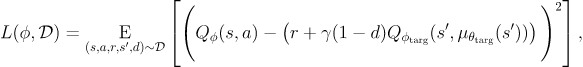

In [5]:
#| echo: false
N=11
scale = 1
space = N*scale

### Implementation
Both the action and observation spaces will have the shape `(3*N, )` (N is the number of squares, so 11) where each square has an x, y and rotation values. The actor's actions simply get added to the current square positions and rotations (since the actor actions can be negative), so the actor can make small adjustments to squeze the squares closer to each other.

The reward function hasn't been developed yet, but it will involve something like steeply punishing overlapping squares, and incentivizing smaller "bounding square" side lengths (like a bounding rectangle, but a square).


I'll be using [Shapely](https://pypi.org/project/shapely/) for the geometry handling:

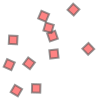

In [7]:
# This is an example of converting the action space into a shapely object
MultiPolygon(convert2shapely([(random.uniform(0, space), random.uniform(0, space), random.uniform(1, 2*math.pi)) for i in range(N)], side_len=scale))

I'll use [Tensorflow](https://www.tensorflow.org/) for the models, this is my proposed actor network structure:

![](model.png)

And for the RL enviorment, I'll use the popular [Gymnasium](https://gymnasium.farama.org/) library, specifically my own personal SimpleGym class which is a helpful abstraction on top of gymnasium:

![](SimpleGymDemo.png)